In [98]:
import spike.spike_analysis.spike_collection as sc
import spike.spike_analysis.spike_recording as sr
import spike.spike_analysis.firing_rate_calculations as fr
import spike.spike_analysis.normalization as norm
import spike.spike_analysis.single_cell as single_cell
import spike.spike_analysis.spike_collection as collection
import spike.spike_analysis.zscoring as zscoring
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import behavior.boris_extraction as boris
import matplotlib.pyplot as plt
import pickle
import re

In [99]:
pd.set_option('display.max_colwidth', 0)  # 0 means unlimited in newer pandas versions

# Show all rows
pd.set_option("display.max_rows", None)

# Show all columns
pd.set_option("display.max_columns", None)

# Don’t truncate column contents
pd.set_option("display.max_colwidth", None)

# Expand the display to the full width of the screen
pd.set_option("display.width", 0)


In [100]:
spike_collection_json_path = r'C:\Users\thoma\Code\ResearchCode\diff_fam_social_memory_ephys\spike_collection.json\spike_collection.json'

In [101]:
import importlib
importlib.reload(sc)
importlib.reload(zscoring)

<module 'spike.spike_analysis.zscoring' from 'c:\\Users\\thoma\\Code\\ResearchCode\\diff_fam_social_memory_ephys\\spike\\spike_analysis\\zscoring.py'>

In [102]:
sp = sc.SpikeCollection.load_collection(spike_collection_json_path)

In [103]:
rec_events = sp.recordings[0].event_dict

# get unique event names from rec_events dictionary
event_names = list(rec_events.keys())
print("Unique event names:", event_names)

Unique event names: ['alone_rewarded', 'alone_rewarded_baseline', 'high_comp', 'high_comp_lose', 'high_comp_lose_baseline', 'high_comp_win', 'high_comp_win_baseline', 'lose', 'low_comp', 'low_comp_lose', 'low_comp_lose_baseline', 'low_comp_win', 'low_comp_win_baseline', 'overall_pretone', 'win']


In [108]:
i = 0
for rec in sp.recordings:
    i+=1
    print(f"{i}: {rec.name}")

1: 20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec
2: 20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged.rec
3: 20230612_112630_standard_comp_to_training_D1_subj_1-1_t1b3L_box2_merged.rec
4: 20230612_112630_standard_comp_to_training_D1_subj_1-2_t2b2L_box1_merged.rec
5: 20230613_105657_standard_comp_to_training_D2_subj_1-1_t1b2L_box1_merged.rec
6: 20230613_105657_standard_comp_to_training_D2_subj_1-4_t4b3L_box2_merged.rec
7: 20230614_114041_standard_comp_to_training_D3_subj_1-1_t1b3L_box1_merged.rec
8: 20230614_114041_standard_comp_to_training_D3_subj_1-2_t2b2L_box2_merged.rec
9: 20230616_111904_standard_comp_to_training_D4_subj_1-2_t2b2L_box2_merged.rec
10: 20230616_111904_standard_comp_to_training_D4_subj_1-4_t4b3L_box1_merged.rec
11: 20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged.rec
12: 20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged.rec
13: 20230618_100636_standard_comp_to_omission_D2_

In [109]:
import re

subjects = set()

for rec in sp.recordings:
    match = re.search(r"subj_([0-9-]+)", rec.name)
    if match:
        subjects.add(match.group(1))

print("Unique subjects:", len(subjects))
print("Subject IDs:", sorted(subjects))


Unique subjects: 11
Subject IDs: ['1-1', '1-2', '1-3', '1-4', '3-1', '3-3', '3-4', '4-2', '4-3', '5-2', '5-3']


In [110]:
# First let's examine the structure of the event data
rec_events = sp.recordings[0].event_dict
print("Event dict keys:", list(rec_events.keys()))
print()

# Check the structure of high_comp and low_comp events
if 'high_comp' in rec_events:
    print("high_comp type:", type(rec_events['high_comp']))
    print("high_comp shape/len:", np.array(rec_events['high_comp']).shape if hasattr(rec_events['high_comp'], '__len__') else 'scalar')
    print("high_comp sample:", rec_events['high_comp'][:5] if len(rec_events['high_comp']) > 0 else 'empty')
    print()

if 'low_comp' in rec_events:
    print("low_comp type:", type(rec_events['low_comp']))
    print("low_comp shape/len:", np.array(rec_events['low_comp']).shape if hasattr(rec_events['low_comp'], '__len__') else 'scalar')
    print("low_comp sample:", rec_events['low_comp'][:5] if len(rec_events['low_comp']) > 0 else 'empty')

Event dict keys: ['alone_rewarded', 'alone_rewarded_baseline', 'high_comp', 'high_comp_lose', 'high_comp_lose_baseline', 'high_comp_win', 'high_comp_win_baseline', 'lose', 'low_comp', 'low_comp_lose', 'low_comp_lose_baseline', 'low_comp_win', 'low_comp_win_baseline', 'overall_pretone', 'win']

high_comp type: <class 'numpy.ndarray'>
high_comp shape/len: (9, 2)
high_comp sample: [[1064110.65 1074110.6 ]
 [ 649110.85  659110.85]
 [ 754110.9   764110.75]
 [ 949110.75  959110.6 ]
 [1014110.55 1024110.55]]

low_comp type: <class 'numpy.ndarray'>
low_comp shape/len: (11, 2)
low_comp sample: [[ 49111.45  59111.3 ]
 [284111.25 294111.1 ]
 [374111.2  384111.05]
 [429111.   439111.15]
 [574111.05 584111.05]]


In [111]:
len(sp.recordings)

39

In [112]:
def extract_competition_events_per_recording(spike_collection):
    """Extract high_comp and low_comp events for each recording"""
    competition_data = []
    
    for i, rec in enumerate(spike_collection.recordings):
        rec_events = rec.event_dict
        
        # Get high_comp and low_comp events
        high_comp_times = rec_events.get('high_comp', np.array([]))
        low_comp_times = rec_events.get('low_comp', np.array([]))
        
        # Create combined list with labels
        events = []
        
        # Handle high_comp events (each row is [start_time, end_time])
        if len(high_comp_times) > 0:
            for event_times in high_comp_times:
                start_time = float(event_times[0])  # Use start time
                events.append((start_time, 1, 'high_comp'))  # 1 for high competition
                
        # Handle low_comp events
        if len(low_comp_times) > 0:
            for event_times in low_comp_times:
                start_time = float(event_times[0])  # Use start time
                events.append((start_time, 0, 'low_comp'))   # 0 for low competition
            
        # Sort by time to get chronological order
        events.sort(key=lambda x: x[0])
        
        competition_data.append({
            'recording_idx': i,
            'recording_name': rec.name,
            'events': events,
            'n_high_comp': len(high_comp_times),
            'n_low_comp': len(low_comp_times),
            'total_comp_events': len(events)
        })
        
        print(f"Recording {i}: {rec.name}")
        print(f"  High comp events: {len(high_comp_times)}")
        print(f"  Low comp events: {len(low_comp_times)}")
        print(f"  Total competition events: {len(events)}")
        if len(events) > 0:
            print(f"  First few events: {[(evt[2], evt[1]) for evt in events[:3]]}")
        print()
    
    return competition_data

# Extract the competition event data
comp_data = extract_competition_events_per_recording(sp)

Recording 0: 20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec
  High comp events: 9
  Low comp events: 11
  Total competition events: 20
  First few events: [('low_comp', 0), ('low_comp', 0), ('low_comp', 0)]

Recording 1: 20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged.rec
  High comp events: 9
  Low comp events: 11
  Total competition events: 20
  First few events: [('low_comp', 0), ('low_comp', 0), ('low_comp', 0)]

Recording 2: 20230612_112630_standard_comp_to_training_D1_subj_1-1_t1b3L_box2_merged.rec
  High comp events: 14
  Low comp events: 6
  Total competition events: 20
  First few events: [('high_comp', 1), ('low_comp', 0), ('high_comp', 1)]

Recording 3: 20230612_112630_standard_comp_to_training_D1_subj_1-2_t2b2L_box1_merged.rec
  High comp events: 14
  Low comp events: 6
  Total competition events: 20
  First few events: [('high_comp', 1), ('low_comp', 0), ('high_comp', 1)]

Recording 4: 20230613_105657_standard_comp_to_tr

Recording 0: 20230612_101430_standard_... - 20 trials
Recording 1: 20230612_101430_standard_... - 20 trials
Recording 2: 20230612_112630_standard_... - 20 trials
Recording 3: 20230612_112630_standard_... - 20 trials
Recording 4: 20230613_105657_standard_... - 20 trials
Recording 5: 20230613_105657_standard_... - 20 trials
Recording 6: 20230614_114041_standard_... - 20 trials
Recording 7: 20230614_114041_standard_... - 20 trials
Recording 8: 20230616_111904_standard_... - 20 trials
Recording 9: 20230616_111904_standard_... - 20 trials
Recording 10: 20230617_115521_standard_... - 21 trials
Recording 11: 20230617_115521_standard_... - 21 trials
Recording 12: 20230618_100636_standard_... - 20 trials
Recording 13: 20230618_100636_standard_... - 20 trials
Recording 14: 20230619_115321_standard_... - 19 trials
Recording 15: 20230620_114347_standard_... - 17 trials
Recording 16: 20230620_114347_standard_... - 17 trials
Recording 17: 20230621_111240_standard_... - 20 trials
Recording 18: 202403

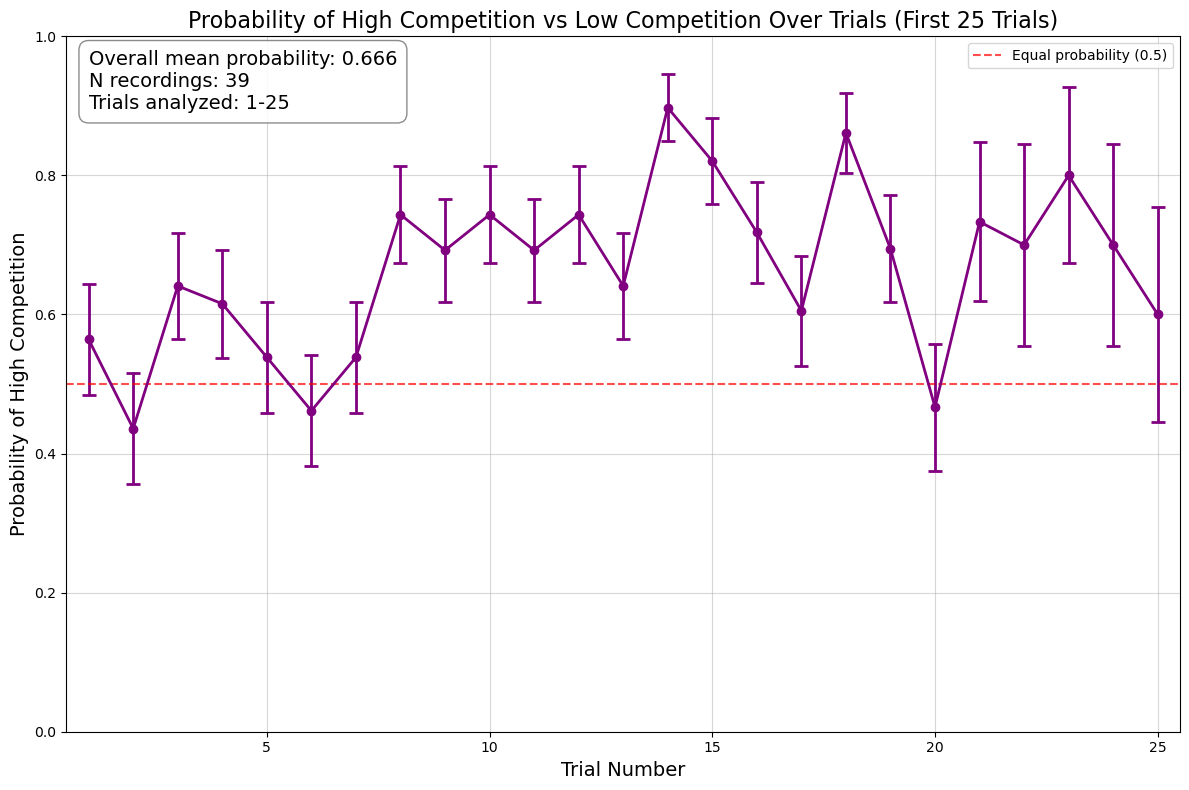

In [113]:
def create_probability_over_trials_plot_debug(comp_data):
    """
    Create probability plot with better debugging and error handling
    Limited to first 25 trials maximum
    """
    # Extract binary sequences for each recording
    sequences = []
    max_trials = 0
        
    for i, data in enumerate(comp_data):
        if data['total_comp_events'] > 0:
            # Extract just the binary values (1=high, 0=low) in chronological order
            binary_sequence = [event[1] for event in data['events']]
            # Limit to first 25 trials
            binary_sequence = binary_sequence[:25]
            sequences.append(binary_sequence)
            max_trials = max(max_trials, len(binary_sequence))
            print(f"Recording {i}: {data['recording_name'][:25]}... - {len(binary_sequence)} trials")
        else:
            print(f"Recording {i}: {data['recording_name'][:25]}... - 0 trials (skipped)")
    
    # Ensure max_trials doesn't exceed 25
    max_trials = min(max_trials, 25)
            
    print(f"\nFound {len(sequences)} recordings with competition events")
    print(f"Maximum trials in any recording (limited to 25): {max_trials}")
    
    if len(sequences) == 0:
        print("No recordings with events found!")
        return None, None, None, None
    
    # Create matrix to store all sequences (pad shorter sequences with NaN)
    trial_matrix = np.full((len(sequences), max_trials), np.nan)
    
    for i, seq in enumerate(sequences):
        trial_matrix[i, :len(seq)] = seq
        
    print(f"\nTrial matrix shape: {trial_matrix.shape}")
    
    # Calculate mean probability and SEM for each trial position
    trial_numbers = []
    probabilities = []
    errors = []
    valid_counts = []  # Track how many recordings contribute to each trial
    
    for trial_idx in range(max_trials):
        # Get all valid (non-NaN) values for this trial position
        trial_values = trial_matrix[:, trial_idx]
        valid_values = trial_values[~np.isnan(trial_values)]
        n_valid = len(valid_values)
        
        print(f"Trial {trial_idx + 1}: {n_valid} recordings with data")
        
        if n_valid > 0:  # Changed from > 1 to > 0 to include single values
            prob = np.mean(valid_values)
            if n_valid > 1:
                sem = np.std(valid_values) / np.sqrt(n_valid)
            else:
                sem = 0  # No error for single value
            
            trial_numbers.append(trial_idx + 1)  # Trial numbers start from 1
            probabilities.append(prob)
            errors.append(sem)
            valid_counts.append(n_valid)
        else:
            print(f"  -> Skipping trial {trial_idx + 1} (no data)")
    
    # Convert to numpy arrays
    trial_numbers = np.array(trial_numbers)
    probabilities = np.array(probabilities)
    errors = np.array(errors)
    
    print(f"\nFinal data points: {len(trial_numbers)}")
    print(f"Trial range: {trial_numbers[0]} to {trial_numbers[-1]}")
    print(f"Probability range: {np.min(probabilities):.3f} to {np.max(probabilities):.3f}")
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    plt.errorbar(trial_numbers, probabilities, yerr=errors, 
                 marker='o', linewidth=2, capsize=5, capthick=2, markersize=6,
                 color='purple')
    
    plt.xlabel('Trial Number', fontsize=14)
    plt.ylabel('Probability of High Competition', fontsize=14)
    plt.title('Probability of High Competition vs Low Competition Over Trials (First 25 Trials)', fontsize=16)
    plt.grid(True, alpha=0.5)
    plt.ylim(0, 1)
    plt.xlim(0.5, 25.5)  # Set x-axis limits to show trials 1-25
    
    # Add horizontal line at 0.5 for reference
    plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, 
                label='Equal probability (0.5)')
    
    plt.legend()

    # Add summary statistics with bigger text and box
    overall_mean = np.mean(probabilities)
    plt.text(0.02, 0.98, f'Overall mean probability: {overall_mean:.3f}\nN recordings: {len(sequences)}\nTrials analyzed: 1-{max_trials}', 
            transform=plt.gca().transAxes, verticalalignment='top',
            fontsize=14,  # Bigger text
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='gray'))  # Bigger box with border
    
    plt.tight_layout()
    plt.show()
    
    return trial_numbers, probabilities, errors, sequences

# Test the debugged version
trial_nums_debug, probs_debug, errs_debug, seqs_debug = create_probability_over_trials_plot_debug(comp_data)

In [114]:
def create_trial_composition_analysis(comp_data_win_lose):
    """
    Create comprehensive trial type composition analysis
    Shows percentage of high comp vs low comp, and win vs lose breakdown
    """
    
    # Extract data for analysis
    composition_data = []
    
    for data in comp_data_win_lose:
        if data['total_comp_events'] > 0:
            total_events = data['total_comp_events']
            
            # Calculate percentages
            pct_high_comp = (data['n_high_comp'] / total_events) * 100
            pct_low_comp = (data['n_low_comp'] / total_events) * 100
            
            # Win/lose percentages within each competition type
            pct_high_win = (data['n_high_comp_win'] / total_events) * 100 if total_events > 0 else 0
            pct_high_lose = (data['n_high_comp_lose'] / total_events) * 100 if total_events > 0 else 0
            pct_low_win = (data['n_low_comp_win'] / total_events) * 100 if total_events > 0 else 0
            pct_low_lose = (data['n_low_comp_lose'] / total_events) * 100 if total_events > 0 else 0
            
            # Extract subject ID from recording name
            subject_match = re.search(r"subj_([0-9-]+)", data['recording_name'])
            subject_id = subject_match.group(1) if subject_match else f"rec_{data['recording_idx']}"
            
            # Extract trial type
            if 'standard_comp' in data['recording_name']:
                trial_type = 'standard'
            elif 'long_comp' in data['recording_name']:
                trial_type = 'long'
            elif 'alone_comp' in data['recording_name']:
                trial_type = 'alone'
            else:
                trial_type = 'unknown'
            
            composition_data.append({
                'recording_idx': data['recording_idx'],
                'recording_name': data['recording_name'],
                'subject_id': subject_id,
                'trial_type': trial_type,
                'total_events': total_events,
                'pct_high_comp': pct_high_comp,
                'pct_low_comp': pct_low_comp,
                'pct_high_win': pct_high_win,
                'pct_high_lose': pct_high_lose,
                'pct_low_win': pct_low_win,
                'pct_low_lose': pct_low_lose
            })
    
    return composition_data

# Create composition data
composition_data = create_trial_composition_analysis(comp_data_win_lose)
print(f"Processed {len(composition_data)} recordings with competition events")

# Convert to DataFrame for easier analysis
import pandas as pd
comp_df = pd.DataFrame(composition_data)
print("\\nDataFrame shape:", comp_df.shape)
print("\\nFirst few rows:")
print(comp_df[['subject_id', 'trial_type', 'total_events', 'pct_high_comp', 'pct_low_comp']].head())

Processed 39 recordings with competition events
\nDataFrame shape: (39, 11)
\nFirst few rows:
  subject_id trial_type  total_events  pct_high_comp  pct_low_comp
0        1-3   standard            20           45.0          55.0
1        1-4   standard            20           45.0          55.0
2        1-1   standard            20           70.0          30.0
3        1-2   standard            20           70.0          30.0
4        1-1   standard            20           55.0          45.0


In [116]:
# Check comp_df structure
print("Comp_df columns:", comp_df.columns.tolist())
print("\nComp_df head:")
print(comp_df.head())
print("\nComp_df shape:", comp_df.shape)

Comp_df columns: ['recording_idx', 'recording_name', 'subject_id', 'trial_type', 'total_events', 'pct_high_comp', 'pct_low_comp', 'pct_high_win', 'pct_high_lose', 'pct_low_win', 'pct_low_lose']

Comp_df head:
   recording_idx  \
0              0   
1              1   
2              2   
3              3   
4              4   

                                                                recording_name  \
0  20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
1  20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged.rec   
2  20230612_112630_standard_comp_to_training_D1_subj_1-1_t1b3L_box2_merged.rec   
3  20230612_112630_standard_comp_to_training_D1_subj_1-2_t2b2L_box1_merged.rec   
4  20230613_105657_standard_comp_to_training_D2_subj_1-1_t1b2L_box1_merged.rec   

  subject_id trial_type  total_events  pct_high_comp  pct_low_comp  \
0        1-3   standard            20           45.0          55.0   
1        1-4   standard            20

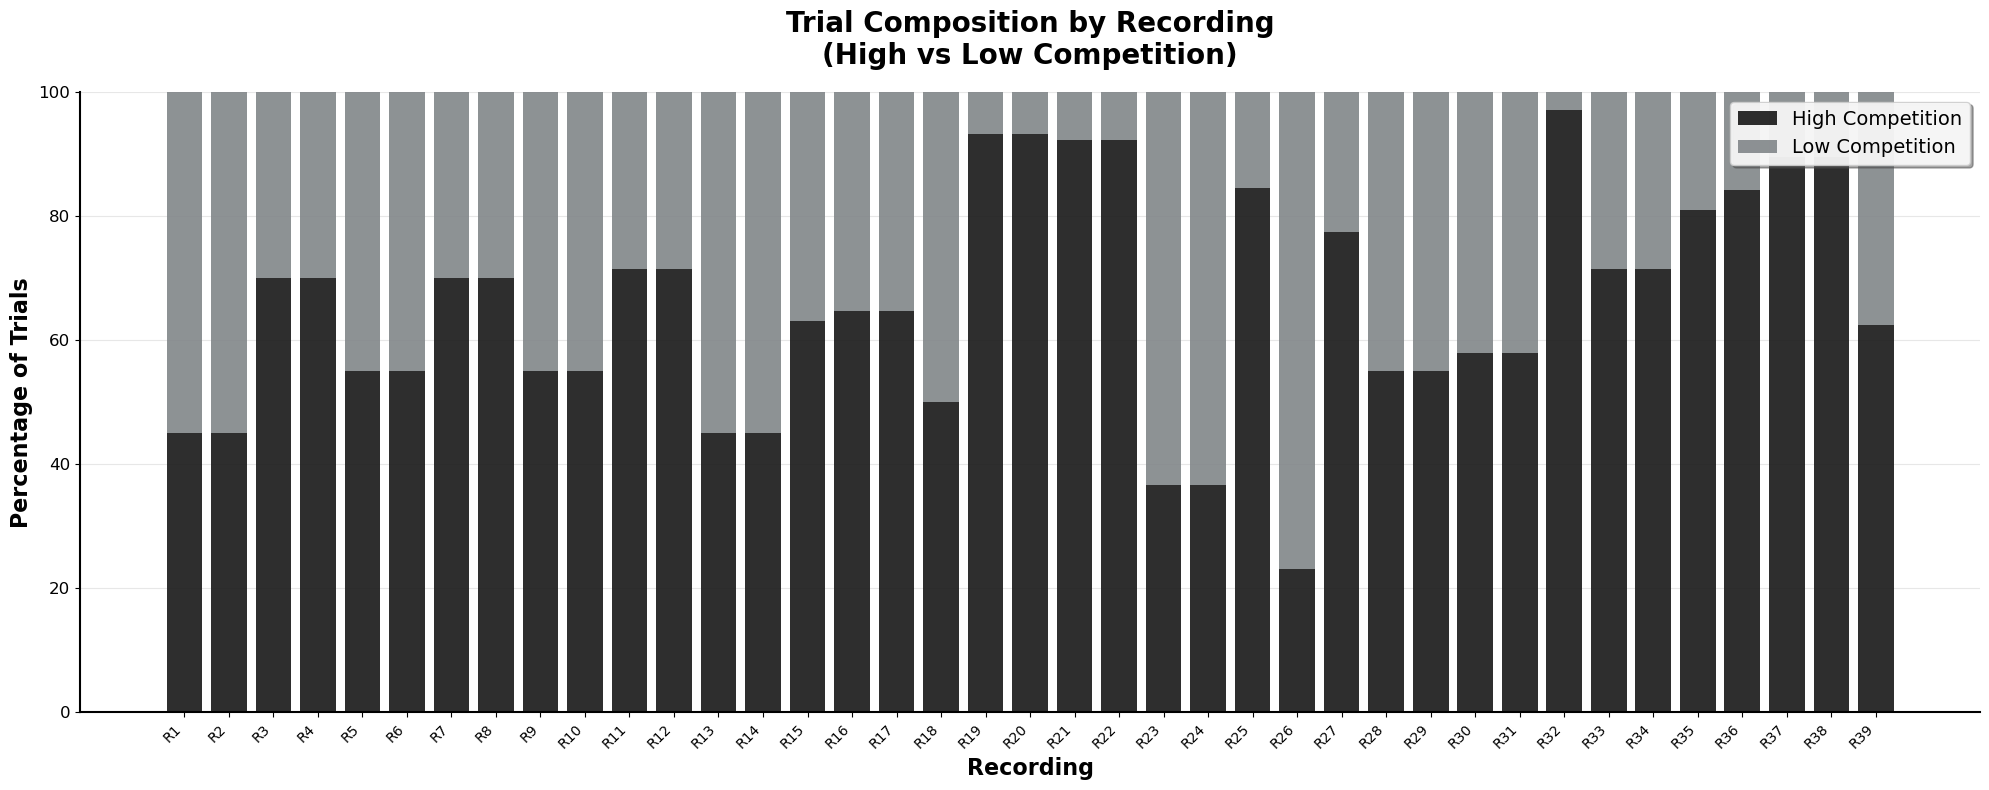

Trial Composition Summary:
Total recordings: 39
Mean high competition: 65.8% (±18.2)
Mean low competition: 34.2% (±18.2)
Range high competition: 23.1% - 97.1%


In [117]:
def create_standalone_trial_composition_plot(comp_df):
    """
    Create a standalone trial composition plot by recording
    Optimized for 39 recordings with clean formatting
    """
    
    # Set up colors as specified
    high_comp_color = '#171717'  # Dark gray/black for high comp
    low_comp_color = '#818689'   # Light gray for low comp
    
    # Create figure with optimized size for 39 recordings
    fig, ax = plt.subplots(figsize=(20, 8))
    
    # Get data
    recordings = comp_df.index
    high_pcts = comp_df['pct_high_comp']
    low_pcts = comp_df['pct_low_comp']
    
    # Create x positions
    x_pos = np.arange(len(recordings))
    
    # Create stacked bars
    bars1 = ax.bar(x_pos, high_pcts, color=high_comp_color, alpha=0.9, 
                   label='High Competition', width=0.8)
    bars2 = ax.bar(x_pos, low_pcts, bottom=high_pcts, color=low_comp_color, 
                   alpha=0.9, label='Low Competition', width=0.8)
    
    # Styling
    ax.set_xlabel('Recording', fontsize=16, fontweight='bold')
    ax.set_ylabel('Percentage of Trials', fontsize=16, fontweight='bold')
    ax.set_title('Trial Composition by Recording\n(High vs Low Competition)', 
                fontsize=20, fontweight='bold', pad=20)
    
    # Set x-axis
    ax.set_xticks(x_pos)
    # Create cleaner x-axis labels - just use recording numbers
    recording_labels = [f'R{i+1}' for i in range(len(recordings))]
    ax.set_xticklabels(recording_labels, rotation=45, ha='right', fontsize=10)
    
    # Y-axis formatting
    ax.set_ylim(0, 100)
    ax.tick_params(axis='y', labelsize=12)
    
    # Legend
    ax.legend(fontsize=14, loc='upper right', framealpha=0.9, 
             fancybox=True, shadow=True)
    
    # Grid for better readability
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_axisbelow(True)
    
    # Remove top and right spines for cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add subtle border around the plot area
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
    
    plt.tight_layout()
    plt.show()
    
    # Print some summary info
    print(f"Trial Composition Summary:")
    print(f"Total recordings: {len(recordings)}")
    print(f"Mean high competition: {high_pcts.mean():.1f}% (±{high_pcts.std():.1f})")
    print(f"Mean low competition: {low_pcts.mean():.1f}% (±{low_pcts.std():.1f})")
    print(f"Range high competition: {high_pcts.min():.1f}% - {high_pcts.max():.1f}%")

# Create the standalone plot
create_standalone_trial_composition_plot(comp_df)

Version 2: Dark theme with external legend


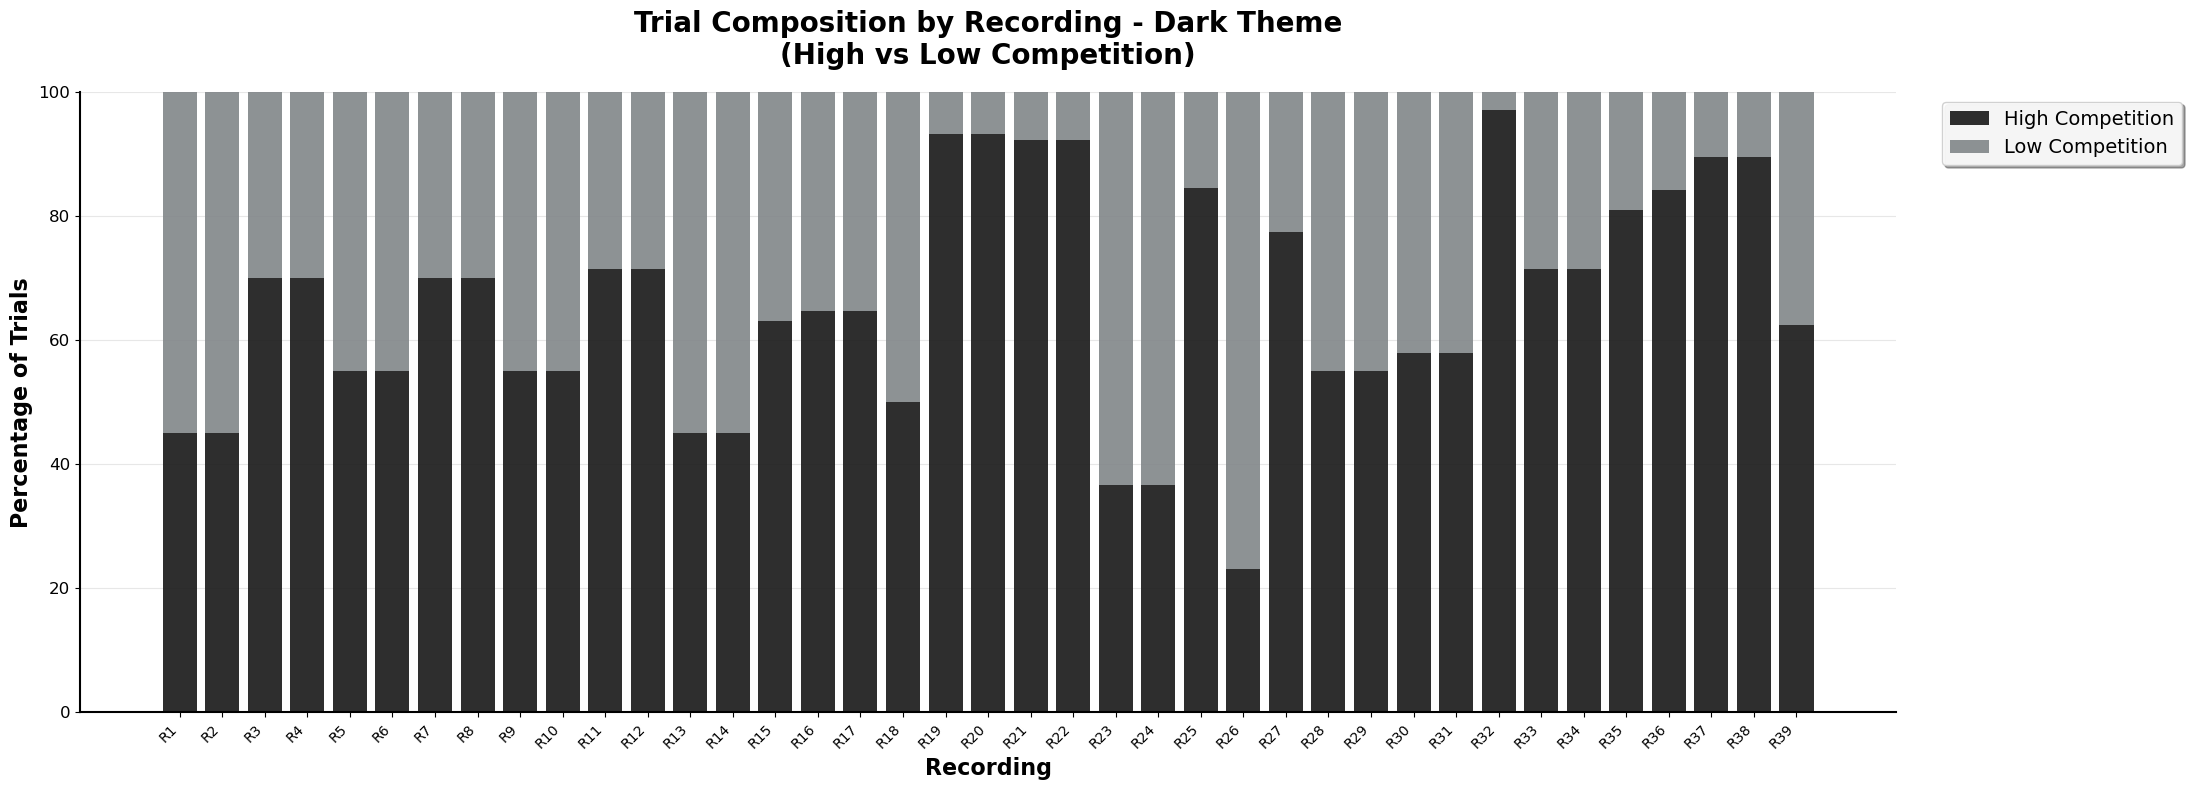


Version 3: Purple/Mustard theme with external legend


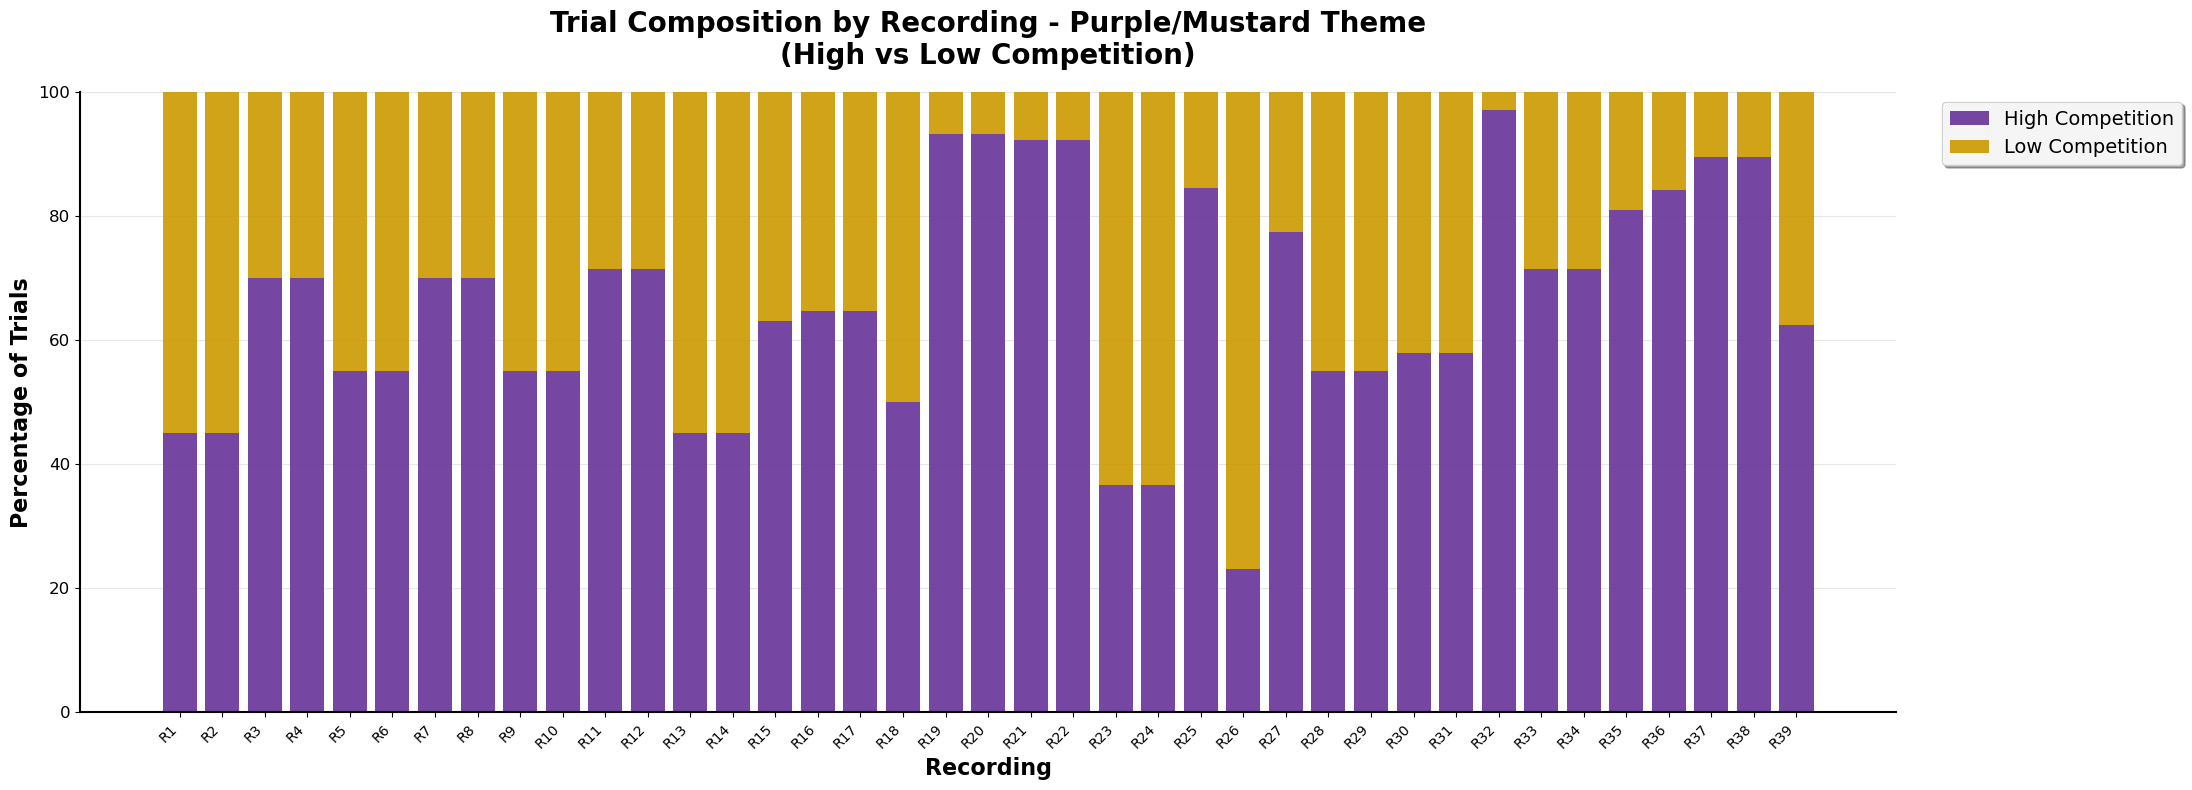

Trial Composition Summary:
Total recordings: 39
Mean high competition: 65.8% (±18.2)
Mean low competition: 34.2% (±18.2)
Range high competition: 23.1% - 97.1%


In [118]:
def create_standalone_trial_composition_plot_v2(comp_df):
    """
    Create a standalone trial composition plot by recording - Version 2
    Legend positioned outside bar area, alternative color scheme
    """
    
    # Set up colors as specified
    high_comp_color = '#171717'  # Dark gray/black for high comp
    low_comp_color = '#818689'   # Light gray for low comp
    
    # Create figure with optimized size for 39 recordings
    fig, ax = plt.subplots(figsize=(22, 8))  # Slightly wider to accommodate external legend
    
    # Get data
    recordings = comp_df.index
    high_pcts = comp_df['pct_high_comp']
    low_pcts = comp_df['pct_low_comp']
    
    # Create x positions
    x_pos = np.arange(len(recordings))
    
    # Create stacked bars
    bars1 = ax.bar(x_pos, high_pcts, color=high_comp_color, alpha=0.9, 
                   label='High Competition', width=0.8)
    bars2 = ax.bar(x_pos, low_pcts, bottom=high_pcts, color=low_comp_color, 
                   alpha=0.9, label='Low Competition', width=0.8)
    
    # Styling
    ax.set_xlabel('Recording', fontsize=16, fontweight='bold')
    ax.set_ylabel('Percentage of Trials', fontsize=16, fontweight='bold')
    ax.set_title('Trial Composition by Recording - Dark Theme\n(High vs Low Competition)', 
                fontsize=20, fontweight='bold', pad=20)
    
    # Set x-axis
    ax.set_xticks(x_pos)
    # Create cleaner x-axis labels - just use recording numbers
    recording_labels = [f'R{i+1}' for i in range(len(recordings))]
    ax.set_xticklabels(recording_labels, rotation=45, ha='right', fontsize=10)
    
    # Y-axis formatting
    ax.set_ylim(0, 100)
    ax.tick_params(axis='y', labelsize=12)
    
    # Legend positioned outside the plot area (upper right)
    ax.legend(fontsize=14, loc='upper left', bbox_to_anchor=(1.02, 1), 
             framealpha=0.9, fancybox=True, shadow=True)
    
    # Grid for better readability
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_axisbelow(True)
    
    # Remove top and right spines for cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add subtle border around the plot area
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
    
    plt.tight_layout()
    plt.show()

def create_standalone_trial_composition_plot_v3(comp_df):
    """
    Create a standalone trial composition plot by recording - Version 3
    Alternative color scheme with legend outside bar area
    """
    
    # Alternative color scheme - Purple and Mustard
    high_comp_color = '#663399'  # Dark purple for high comp
    low_comp_color = '#CC9900'   # Mustard for low comp
    
    # Create figure with optimized size for 39 recordings
    fig, ax = plt.subplots(figsize=(22, 8))  # Slightly wider to accommodate external legend
    
    # Get data
    recordings = comp_df.index
    high_pcts = comp_df['pct_high_comp']
    low_pcts = comp_df['pct_low_comp']
    
    # Create x positions
    x_pos = np.arange(len(recordings))
    
    # Create stacked bars
    bars1 = ax.bar(x_pos, high_pcts, color=high_comp_color, alpha=0.9, 
                   label='High Competition', width=0.8)
    bars2 = ax.bar(x_pos, low_pcts, bottom=high_pcts, color=low_comp_color, 
                   alpha=0.9, label='Low Competition', width=0.8)
    
    # Styling
    ax.set_xlabel('Recording', fontsize=16, fontweight='bold')
    ax.set_ylabel('Percentage of Trials', fontsize=16, fontweight='bold')
    ax.set_title('Trial Composition by Recording - Purple/Mustard Theme\n(High vs Low Competition)', 
                fontsize=20, fontweight='bold', pad=20)
    
    # Set x-axis
    ax.set_xticks(x_pos)
    # Create cleaner x-axis labels - just use recording numbers
    recording_labels = [f'R{i+1}' for i in range(len(recordings))]
    ax.set_xticklabels(recording_labels, rotation=45, ha='right', fontsize=10)
    
    # Y-axis formatting
    ax.set_ylim(0, 100)
    ax.tick_params(axis='y', labelsize=12)
    
    # Legend positioned outside the plot area (upper right)
    ax.legend(fontsize=14, loc='upper left', bbox_to_anchor=(1.02, 1), 
             framealpha=0.9, fancybox=True, shadow=True)
    
    # Grid for better readability
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_axisbelow(True)
    
    # Remove top and right spines for cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add subtle border around the plot area
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
    
    plt.tight_layout()
    plt.show()
    
    # Print some summary info
    print(f"Trial Composition Summary:")
    print(f"Total recordings: {len(recordings)}")
    print(f"Mean high competition: {high_pcts.mean():.1f}% (±{high_pcts.std():.1f})")
    print(f"Mean low competition: {low_pcts.mean():.1f}% (±{low_pcts.std():.1f})")
    print(f"Range high competition: {high_pcts.min():.1f}% - {high_pcts.max():.1f}%")

# Create both versions
print("Version 2: Dark theme with external legend")
create_standalone_trial_composition_plot_v2(comp_df)

print("\nVersion 3: Purple/Mustard theme with external legend")
create_standalone_trial_composition_plot_v3(comp_df)

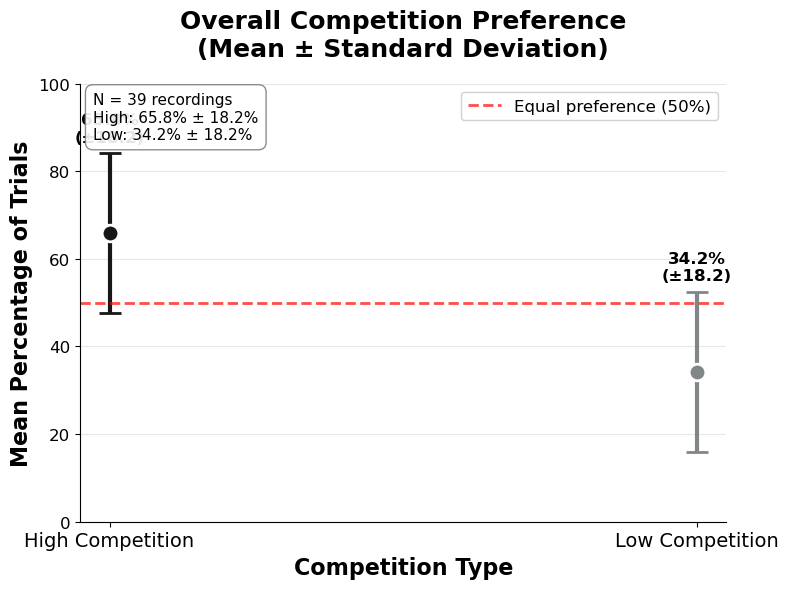

Competition Preference Summary:
High Competition: 65.8% (±18.2%)
Low Competition: 34.2% (±18.2%)
Preference ratio (High:Low): 1.93:1


In [119]:
def create_mean_competition_plot(comp_df):
    """
    Create a simple point plot showing mean high vs low competition with error bars
    """
    
    # Calculate means and standard deviations
    high_mean = comp_df['pct_high_comp'].mean()
    high_std = comp_df['pct_high_comp'].std()
    low_mean = comp_df['pct_low_comp'].mean()
    low_std = comp_df['pct_low_comp'].std()
    
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Data for plotting
    categories = ['High Competition', 'Low Competition']
    means = [high_mean, low_mean]
    errors = [high_std, low_std]
    
    # Colors matching your theme
    colors = ['#171717', '#818689']  # Dark gray/black and light gray
    
    # Create point plot with error bars
    x_pos = np.arange(len(categories))
    
    # Plot points with error bars
    for i, (mean_val, error_val, color) in enumerate(zip(means, errors, colors)):
        ax.errorbar(x_pos[i], mean_val, yerr=error_val, 
                   marker='o', markersize=12, capsize=8, capthick=3, 
                   linewidth=3, color=color, markerfacecolor=color, 
                   markeredgecolor='white', markeredgewidth=2)
        
        # Add value labels above points
        ax.text(x_pos[i], mean_val + error_val + 2, 
               f'{mean_val:.1f}%\n(±{error_val:.1f})', 
               ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # Styling
    ax.set_xlabel('Competition Type', fontsize=16, fontweight='bold')
    ax.set_ylabel('Mean Percentage of Trials', fontsize=16, fontweight='bold')
    ax.set_title('Overall Competition Preference\n(Mean ± Standard Deviation)', 
                fontsize=18, fontweight='bold', pad=20)
    
    # Set x-axis
    ax.set_xticks(x_pos)
    ax.set_xticklabels(categories, fontsize=14)
    
    # Y-axis formatting
    ax.set_ylim(0, 100)
    ax.tick_params(axis='y', labelsize=12)
    
    # Add horizontal line at 50% for reference
    ax.axhline(y=50, color='red', linestyle='--', alpha=0.7, linewidth=2,
               label='Equal preference (50%)')
    
    # Grid for better readability
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_axisbelow(True)
    
    # Remove top and right spines for cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add legend
    ax.legend(fontsize=12, loc='upper right', framealpha=0.9)
    
    # Add summary text box
    summary_text = f'N = {len(comp_df)} recordings\nHigh: {high_mean:.1f}% ± {high_std:.1f}%\nLow: {low_mean:.1f}% ± {low_std:.1f}%'
    ax.text(0.02, 0.98, summary_text, transform=ax.transAxes, 
           verticalalignment='top', fontsize=11,
           bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='gray'))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"Competition Preference Summary:")
    print(f"High Competition: {high_mean:.1f}% (±{high_std:.1f}%)")
    print(f"Low Competition: {low_mean:.1f}% (±{low_std:.1f}%)")
    print(f"Preference ratio (High:Low): {high_mean/low_mean:.2f}:1")

# Create the mean competition plot
create_mean_competition_plot(comp_df)

Version 1: Dark theme with closer positioning and external legend


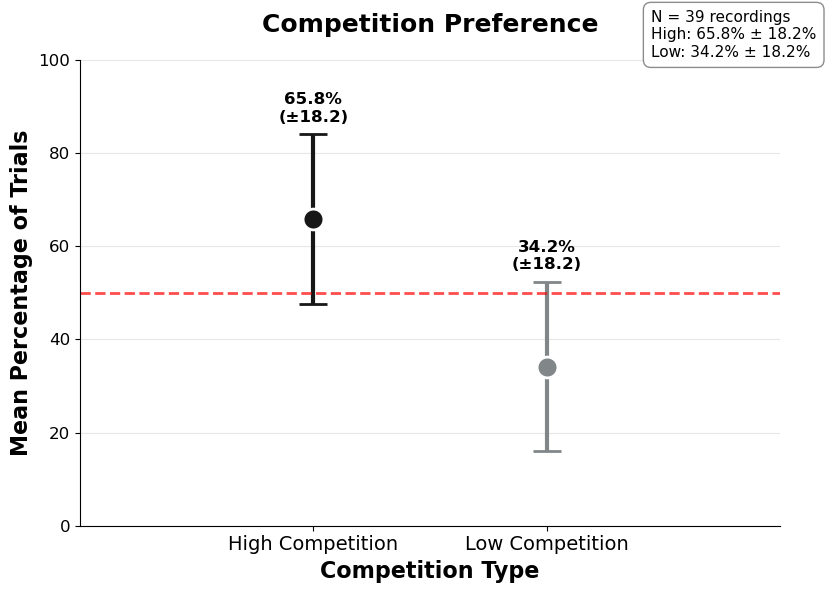


Version 2: Purple/Mustard theme with closer positioning and external legend


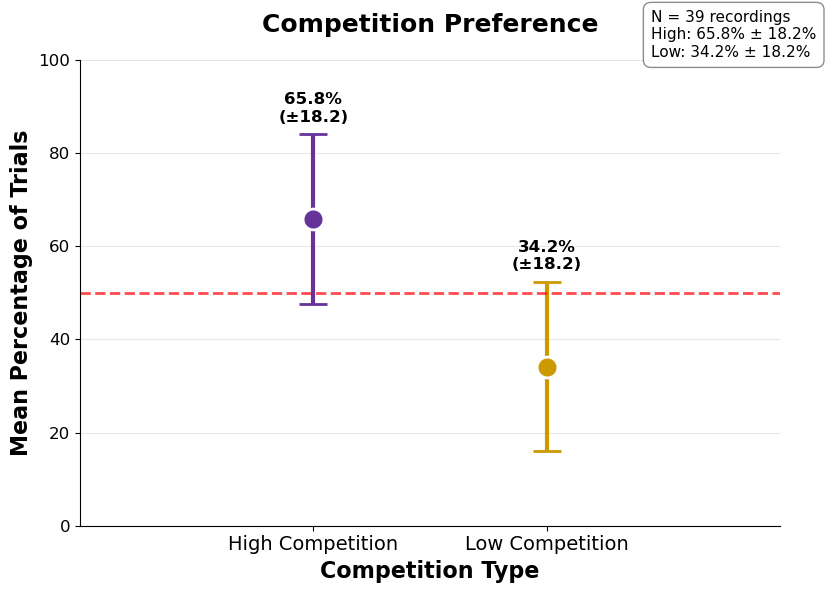

Competition Preference Summary:
High Competition: 65.8% (±18.2%)
Low Competition: 34.2% (±18.2%)
Preference ratio (High:Low): 1.93:1


In [120]:
def create_mean_competition_plot_closer(comp_df):
    """
    Create a simple point plot showing mean high vs low competition with error bars
    Points positioned closer together
    """
    
    # Calculate means and standard deviations
    high_mean = comp_df['pct_high_comp'].mean()
    high_std = comp_df['pct_high_comp'].std()
    low_mean = comp_df['pct_low_comp'].mean()
    low_std = comp_df['pct_low_comp'].std()
    
    # Create figure - wider to accommodate external legend
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Data for plotting
    categories = ['High Competition', 'Low Competition']
    means = [high_mean, low_mean]
    errors = [high_std, low_std]
    
    # Colors matching your theme
    colors = ['#171717', '#818689']  # Dark gray/black and light gray
    
    # Create point plot with error bars - closer positioning
    x_pos = np.array([0.4, 0.6])  # Closer positions instead of [0, 1]
    
    # Plot points with error bars
    for i, (mean_val, error_val, color) in enumerate(zip(means, errors, colors)):
        ax.errorbar(x_pos[i], mean_val, yerr=error_val, 
                   marker='o', markersize=15, capsize=10, capthick=3, 
                   linewidth=3, color=color, markerfacecolor=color, 
                   markeredgecolor='white', markeredgewidth=2)
        
        # Add value labels above points
        ax.text(x_pos[i], mean_val + error_val + 2, 
               f'{mean_val:.1f}%\n(±{error_val:.1f})', 
               ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # Styling - shorter title
    ax.set_xlabel('Competition Type', fontsize=16, fontweight='bold')
    ax.set_ylabel('Mean Percentage of Trials', fontsize=16, fontweight='bold')
    ax.set_title('Competition Preference', 
                fontsize=18, fontweight='bold', pad=20)
    
    # Set x-axis with closer range
    ax.set_xticks(x_pos)
    ax.set_xticklabels(categories, fontsize=14)
    ax.set_xlim(0.2, 0.8)  # Tighter x-axis range
    
    # Y-axis formatting
    ax.set_ylim(0, 100)
    ax.tick_params(axis='y', labelsize=12)
    
    # Add horizontal line at 50% for reference
    ax.axhline(y=50, color='red', linestyle='--', alpha=0.7, linewidth=2,
               label='Equal preference (50%)')
    
    # Grid for better readability
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_axisbelow(True)
    
    # Remove top and right spines for cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add summary text box
    summary_text = f'N = {len(comp_df)} recordings\nHigh: {high_mean:.1f}% ± {high_std:.1f}%\nLow: {low_mean:.1f}% ± {low_std:.1f}%'
    fig.text(
        0.82, 0.98, summary_text,   # x ~0.82 (right margin), y ~0.9 (near top)
        va='top', ha='left', fontsize=11,
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='gray')
    )


    plt.tight_layout()
    plt.show()

def create_mean_competition_plot_alt_colors(comp_df):
    """
    Create a simple point plot showing mean high vs low competition with error bars
    Using alternative purple/mustard color scheme, points closer together
    """
    
    # Calculate means and standard deviations
    high_mean = comp_df['pct_high_comp'].mean()
    high_std = comp_df['pct_high_comp'].std()
    low_mean = comp_df['pct_low_comp'].mean()
    low_std = comp_df['pct_low_comp'].std()
    
    # Create figure - wider to accommodate external legend
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Data for plotting
    categories = ['High Competition', 'Low Competition']
    means = [high_mean, low_mean]
    errors = [high_std, low_std]
    
    # Alternative colors - purple and mustard/yellow
    colors = ['#663399', '#CC9900']  # Purple and mustard yellow
    
    # Create point plot with error bars - closer positioning
    x_pos = np.array([0.4, 0.6])  # Closer positions instead of [0, 1]
    
    # Plot points with error bars
    for i, (mean_val, error_val, color) in enumerate(zip(means, errors, colors)):
        ax.errorbar(x_pos[i], mean_val, yerr=error_val, 
                   marker='o', markersize=15, capsize=10, capthick=3, 
                   linewidth=3, color=color, markerfacecolor=color, 
                   markeredgecolor='white', markeredgewidth=2)
        
        # Add value labels above points
        ax.text(x_pos[i], mean_val + error_val + 2, 
               f'{mean_val:.1f}%\n(±{error_val:.1f})', 
               ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # Styling - shorter title
    ax.set_xlabel('Competition Type', fontsize=16, fontweight='bold')
    ax.set_ylabel('Mean Percentage of Trials', fontsize=16, fontweight='bold')
    ax.set_title('Competition Preference', 
                fontsize=18, fontweight='bold', pad=20)
    
    # Set x-axis with closer range
    ax.set_xticks(x_pos)
    ax.set_xticklabels(categories, fontsize=14)
    ax.set_xlim(0.2, 0.8)  # Tighter x-axis range
    
    # Y-axis formatting
    ax.set_ylim(0, 100)
    ax.tick_params(axis='y', labelsize=12)
    
    # Add horizontal line at 50% for reference
    ax.axhline(y=50, color='red', linestyle='--', alpha=0.7, linewidth=2,
               label='Equal preference (50%)')
    
    # Grid for better readability
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_axisbelow(True)
    
    # Remove top and right spines for cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add margin space for the summary box
    fig.subplots_adjust(right=0.75)

    summary_text = (
        f'N = {len(comp_df)} recordings\n'
        f'High: {high_mean:.1f}% ± {high_std:.1f}%\n'
        f'Low: {low_mean:.1f}% ± {low_std:.1f}%'
    )

    fig.text(
        0.82, 0.98, summary_text,   # x ~0.82 (right margin), y ~0.9 (near top)
        va='top', ha='left', fontsize=11,
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='gray')
    )


    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"Competition Preference Summary:")
    print(f"High Competition: {high_mean:.1f}% (±{high_std:.1f}%)")
    print(f"Low Competition: {low_mean:.1f}% (±{low_std:.1f}%)")
    print(f"Preference ratio (High:Low): {high_mean/low_mean:.2f}:1")

# Create both versions with closer positioning
print("Version 1: Dark theme with closer positioning and external legend")
create_mean_competition_plot_closer(comp_df)

print("\nVersion 2: Purple/Mustard theme with closer positioning and external legend")
create_mean_competition_plot_alt_colors(comp_df)